# Project 4: Multi-factor Model
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [4]:
# !pip install cvxpy

### Load Packages

In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
# import project_tests
# import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### 导入数据

In [2]:
def get_data(symbol, n=None):
    """ Function which returns the data of the symbol"""

    data_df = pd.read_csv(data_path+"/"+symbol+".csv", parse_dates=['DateTime'])
    
    # TODO:改名 DateTime
    data_df = data_df.rename(columns={'DateTime':'datetime', 'Open':'open', 'Low':'low', 'High':'high', 'Close':'close', 'Volume':'volume'})
#     data_df["datetime"] = pd.to_datetime(data_df["datetime"], unit='ms')
    data_df = data_df.set_index('datetime')
    # 取倒数 n 行
    if n is not None:
        data_df = data_df.iloc[-n:]
        
    # 注意，原始数据是15min，这里resmaple成需要的周期。
    data_df = data_df.resample(rule=rule_type, label='left', closed='left').agg(
        {'open': 'first',
         'high': 'max',
         'low': 'min',
         'close': 'last',
         'volume': 'sum',
         })
    
    return data_df

In [3]:
# 数据长度
# TODO:
N_month = 12*3
N_daily_data = 4*24
data_len = N_month*30*N_daily_data
print("data len is ", data_len)

# data resample period
rule_type = '4H'
# 乘以4,代表一天4条数据。
target_data_len = N_month*30*6

data len is  103680


In [4]:

import os
data_path="data"
symbol_list=[]
dirs = os.listdir( data_path )

# 输出所有文件和文件夹
for file in dirs:
#     print(file)
    symbol_list.append(file[:-4])

print(symbol_list)


['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'APE_USDT', 'APT_USDT', 'AR_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BNX_USDT', 'BTC_USDT', 'CELO_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'CVX_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'DYDX_USDT', 'EGLD_USDT', 'ENJ_USDT', 'ENS_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FLOW_USDT', 'FTM_USDT', 'GMT_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'ICP_USDT', 'IMX_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KLAY_USDT', 'KSM_USDT', 'LDO_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MASK_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'OP_USDT', 'QNT_USDT', 'QTUM_USDT', 'ROSE_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']


In [5]:
small_price_thre = 0.00001
small_price_symbols=[]

short_data_symbols=[]

# raw_df = pd.DataFrame()
total_close_df=pd.DataFrame()


# 使用 BTC_USDT 作为初始化。
df = get_data("BTC_USDT", data_len).dropna()
total_close_df["BTC_USDT"] = df["close"].pct_change().fillna(0)

for symbol in symbol_list:
        df = get_data(symbol, data_len).dropna()
        # 过滤掉数据较少的
        if len(df) < target_data_len*0.5:
            short_data_symbols.append(symbol)
            continue
            
        total_close_df[symbol] = df["close"].pct_change().fillna(0)
        # 防止最后一行数据为Nan,所以取倒数第2行。
        if df["close"].iloc[-2] < small_price_thre:
            small_price_symbols.append(symbol)

In [6]:
### 去掉价格过小的品种
print("small price symbol", small_price_symbols)
print("short data symbol", short_data_symbols)
symbol_list = [symbol for symbol in symbol_list if symbol not in small_price_symbols]
symbol_list = [symbol for symbol in symbol_list if symbol not in short_data_symbols]
print("filtered symbol list ", symbol_list)

small price symbol []
short data symbol ['APE_USDT', 'APT_USDT', 'AR_USDT', 'BNX_USDT', 'CELO_USDT', 'CVX_USDT', 'DYDX_USDT', 'ENS_USDT', 'FLOW_USDT', 'GMT_USDT', 'ICP_USDT', 'IMX_USDT', 'KLAY_USDT', 'LDO_USDT', 'MASK_USDT', 'OP_USDT', 'QNT_USDT', 'ROSE_USDT']
filtered symbol list  ['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BTC_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FTM_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KSM_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_

In [7]:
total_close_df = total_close_df.fillna(0)
total_close_df

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 12:00:00,0.005122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 16:00:00,-0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 20:00:00,-0.003983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02 00:00:00,-0.009764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,-0.001479,-0.011687,-0.001567,-0.003482,-0.002903,-0.005459,-0.011097,-0.009029,-0.013550,-0.010336,...,0.014620,-0.000524,-0.001710,-0.006079,-0.008032,0.003721,-0.001007,-0.007944,0.000895,-0.002200
2022-12-01 20:00:00,0.001481,0.004927,-0.000785,-0.001588,0.002496,0.006273,-0.002012,0.004409,0.009858,0.006963,...,0.002712,-0.001572,0.003426,0.000000,-0.000912,0.009582,-0.000756,0.004004,0.005590,0.002646
2022-12-02 00:00:00,-0.004514,-0.018435,-0.008481,-0.006045,-0.014938,-0.008280,0.002947,-0.005706,0.001440,-0.008643,...,0.005917,-0.006824,0.006402,-0.012232,-0.009017,-0.004018,-0.024710,-0.004985,-0.005115,-0.004398


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [8]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    # center data - NB: apparently centering the data beforehand causes the test not to pass
    #returns_demeaned = returns - returns.mean(axis=0)
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca


# project_tests.test_fit_pca(fit_pca)

### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [9]:
num_factor_exposures = 20
pca = fit_pca(total_close_df, num_factor_exposures, 'full')

pca.components_

array([[-0.08269127, -0.12582949, -0.14419353, ..., -0.13812914,
        -0.13438316, -0.13816332],
       [-0.11020575,  0.10272034,  0.11939259, ..., -0.18509186,
        -0.17604423,  0.03125013],
       [-0.01787737,  0.01399492,  0.10206903, ..., -0.01379143,
        -0.03719598,  0.02133922],
       ...,
       [-0.0436325 ,  0.07145519, -0.08460614, ..., -0.05839654,
        -0.16201893,  0.36339171],
       [ 0.00226768, -0.38891062,  0.00392   , ..., -0.10875035,
         0.14281282,  0.16956129],
       [-0.01821315,  0.38795483,  0.10862053, ..., -0.05954711,
        -0.07798541,  0.10240849]])

Let's also look at the PCA's percent of variance explained by each factor

<BarContainer object of 20 artists>

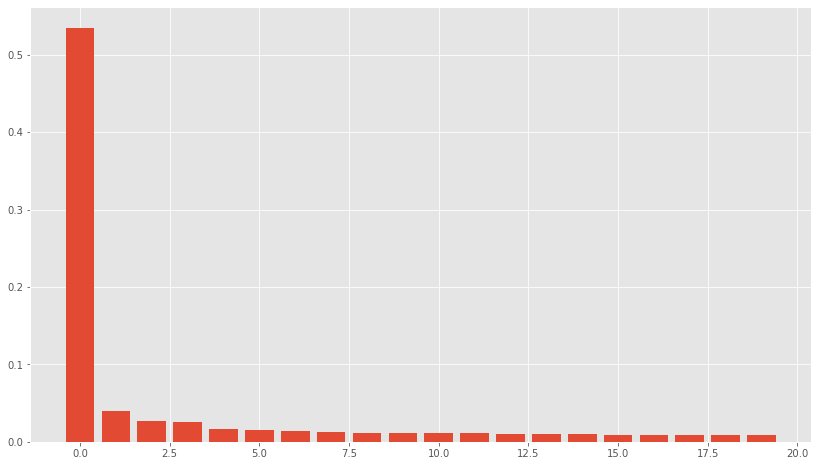

In [10]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [11]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    return factor_betas


# project_tests.test_factor_betas(factor_betas)

### View Data
Let's view the factor betas from this model.

In [12]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, total_close_df.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
BTC_USDT,-0.082691,-0.110206,-0.017877,0.011115,0.008228,-0.044372,0.045686,-0.013377,0.006464,-0.070473,-0.015677,-0.036112,-0.045051,0.020705,-0.025789,-0.015813,0.006417,-0.043632,0.002268,-0.018213
1INCH_USDT,-0.125829,0.102720,0.013995,-0.049528,-0.078444,-0.122758,0.104347,-0.128654,0.050960,-0.140895,-0.073794,0.147374,0.313230,-0.020651,-0.254965,-0.201814,-0.041221,0.071455,-0.388911,0.387955
AAVE_USDT,-0.144194,0.119393,0.102069,-0.024900,-0.055295,-0.101572,0.091699,-0.125436,-0.030813,-0.120529,-0.118881,-0.000234,0.001810,-0.063773,-0.191487,0.063969,-0.023994,-0.084606,0.003920,0.108621
ADA_USDT,-0.126312,-0.150612,0.015801,-0.027382,-0.030998,0.026120,0.038487,0.035153,-0.044177,0.011799,-0.007378,-0.024654,0.021451,0.021619,0.084574,0.112519,-0.048637,0.024257,-0.057792,0.065202
ALGO_USDT,-0.132435,0.021965,0.052148,-0.016586,-0.037470,0.131768,-0.113110,0.026563,-0.082591,0.198458,-0.151111,0.134362,0.117502,-0.033286,0.075406,0.088867,0.100015,-0.040697,0.007470,-0.027331
ATOM_USDT,-0.146646,-0.132628,0.017674,-0.078959,-0.061070,0.059146,-0.046220,0.169615,-0.072575,0.023995,-0.119359,0.251980,0.049631,0.053249,0.130758,0.102811,-0.314909,-0.221183,-0.150815,-0.238719
AVAX_USDT,-0.142928,0.106066,0.021050,-0.008005,-0.178118,-0.061900,0.032819,0.022863,-0.029262,-0.120765,0.037718,-0.019540,0.034756,0.075996,0.102879,0.203320,-0.196555,0.031112,-0.118404,-0.086151
AXS_USDT,-0.131584,0.167200,-0.210444,-0.087876,0.123069,0.520175,0.667565,-0.084567,0.073521,-0.000826,0.020899,0.040145,0.160533,-0.096837,0.152017,-0.115698,0.137909,-0.051433,-0.043644,-0.176112
BAL_USDT,-0.130842,0.058516,0.109089,-0.006031,0.024889,-0.013083,0.011935,-0.076533,-0.026835,-0.018574,-0.100324,-0.021446,-0.018941,-0.046839,-0.106655,0.007256,0.028913,-0.014519,-0.019600,-0.050762
BAT_USDT,-0.137720,-0.119329,-0.081425,-0.064563,0.050927,0.002110,-0.067809,0.088824,-0.021505,0.133283,-0.077376,0.006153,0.004421,-0.028030,-0.037215,0.077815,-0.159819,-0.093611,-0.133597,-0.016606


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [13]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns = pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    return factor_returns


# project_tests.test_factor_returns(factor_returns)

### View Data
Let's see what these factor returns looks like over time.

<AxesSubplot:xlabel='datetime'>

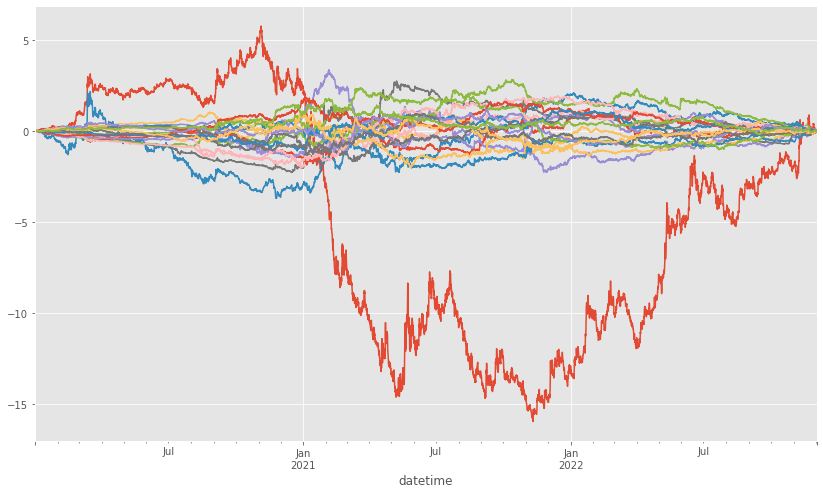

In [14]:
risk_model['factor_returns'] = factor_returns(
    pca,
    total_close_df,
    total_close_df.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

In [15]:
risk_model['factor_returns']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
datetime,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,0.002881,-0.000170,0.000260,-0.000735,0.000157,-0.000643,-0.000638,-0.000330,0.000271,-0.000267,0.000214,0.000594,-0.000006,-0.000842,-0.000070,-0.000442,0.000159,-0.000100,-0.000070,0.000027
2020-01-01 12:00:00,0.001259,-0.002075,0.000570,-0.000812,0.000512,-0.001494,0.000570,-0.000682,0.000314,-0.001483,-0.000296,-0.000282,-0.000848,-0.000631,-0.000876,-0.000001,0.000234,-0.001055,-0.000098,-0.000250
2020-01-01 16:00:00,0.003428,0.000684,0.000283,-0.000766,0.000040,-0.000400,-0.000999,-0.000100,0.000099,0.000119,0.000126,0.000788,0.000337,-0.000916,0.000292,-0.000479,-0.000084,0.000029,-0.000318,0.000033
2020-01-01 20:00:00,0.004764,0.002347,0.000081,-0.000726,-0.000253,0.000281,-0.001974,0.000240,-0.000007,0.001108,0.000431,0.001465,0.001056,-0.001090,0.000998,-0.000796,-0.000243,0.000728,-0.000411,0.000222
2020-01-02 00:00:00,0.006941,0.005798,0.000340,-0.000926,-0.000666,0.001261,-0.003328,0.001124,-0.000701,0.002692,0.000050,0.002201,0.002425,-0.001435,0.002349,-0.000746,-0.001204,0.001231,-0.001398,0.000275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.026753,-0.004287,0.007802,0.008077,-0.001813,-0.012661,0.008294,-0.011451,0.027432,0.011827,-0.008291,-0.018578,-0.011478,0.011224,0.004019,-0.013837,-0.007973,-0.013135,0.000230,0.003143
2022-12-01 20:00:00,-0.004932,-0.000096,0.005358,-0.008944,0.003866,0.007943,-0.004905,0.006837,-0.018427,-0.015247,0.007879,0.017571,0.004040,0.004607,-0.001809,-0.018068,-0.001555,-0.013550,0.003663,0.001317
2022-12-02 00:00:00,0.067407,0.007570,-0.002025,-0.031560,-0.005463,0.009059,-0.002005,-0.017519,-0.009886,-0.008497,-0.005660,0.005782,-0.017936,0.005254,0.007755,0.007757,-0.018003,0.003902,0.004549,-0.002284


## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [16]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : DataFrame
        Factor covariance matrix
    """
    
    factor_cov_matrix = np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)
    return factor_cov_matrix


# project_tests.test_factor_cov_matrix(factor_cov_matrix)

### View Data

In [17]:
ann_factor = 365
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[8.0690513 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.59977018, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.40102452, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.3855145 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [18]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)
    
    return idiosyncratic_var_matrix


# project_tests.test_idiosyncratic_var_matrix(idiosyncratic_var_matrix)

### View Data

In [19]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(total_close_df, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
BTC_USDT,0.025067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1INCH_USDT,0.000000,0.035545,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
AAVE_USDT,0.000000,0.000000,0.056021,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
ADA_USDT,0.000000,0.000000,0.000000,0.058286,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
ALGO_USDT,0.000000,0.000000,0.000000,0.000000,0.076167,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
ATOM_USDT,0.000000,0.000000,0.000000,0.000000,0.000000,0.054836,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
AVAX_USDT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082323,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
AXS_USDT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00308,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
BAL_USDT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.061479,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
BAT_USDT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.072283,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [20]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    idiosyncratic_var_vector = pd.DataFrame(np.max(idiosyncratic_var_matrix, axis=0))
    
    return idiosyncratic_var_vector


# project_tests.test_idiosyncratic_var_vector(idiosyncratic_var_vector)

### View Data

In [21]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(total_close_df, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
BTC_USDT,0.025067
1INCH_USDT,0.035545
AAVE_USDT,0.056021
ADA_USDT,0.058286
ALGO_USDT,0.076167
ATOM_USDT,0.054836
AVAX_USDT,0.082323
AXS_USDT,0.003080
BAL_USDT,0.061479
BAT_USDT,0.072283


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [22]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    # for some reason using multiplication operation * doesn't work even though broadcasting should handle that,
    # gotta resort to ugly np.dot implementation, would appreciate feedback on this
    predict_portfolio_risk = float(np.sqrt( np.dot(np.dot(weights.T,(np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T) + idiosyncratic_var_matrix)),weights)))
    
    return predict_portfolio_risk


# project_tests.test_predict_portfolio_risk(predict_portfolio_risk)

### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.
#### 这里假设使用平均的权重

In [23]:
len(symbol_list)

59

In [24]:
all_weights = pd.DataFrame(np.repeat(1/len(symbol_list), len(symbol_list)), symbol_list)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.36743066129351803

## 因子计算

In [25]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

# pickle/csv在读写double/float类型数据时，可能发生精度的损失，导致符号计算错误。
# 使用自定义的sign，与c++一致。
import math
def mysign(x):
    if math.fabs(x)<1e-8:
        return 0
    elif x>0:
        return 1
    else:
        return -1
    
def ewma(x, halflife, init=0, adjust=False):
    # TODO: halflife 为 0时的默认取值。
    if halflife == 0:
        halflife = 1
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

def get_range_pos(wpr, min_period, max_period, period):
    return zero_divide(wpr-min_period, max_period-min_period).rolling(period).mean() - 0.5

In [26]:
print(symbol_list)

['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BTC_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FTM_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KSM_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']


In [27]:
# 把"BTC_USDT"移到开始
symbol_list.remove("BTC_USDT")
print(symbol_list)
symbol_list.insert(0, "BTC_USDT")
print(symbol_list)

['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FTM_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KSM_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']
['BTC_USDT', '1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', '

In [28]:
len(symbol_list)

59

In [29]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

factor_df = {}

for symbol in tqdm(symbol_list):
    print(symbol)
    
    
    # Import the data
    df = get_data(symbol, data_len).dropna()
    
    # return 为相比上一次价格的涨幅比例
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    
    period=20
    df["nr"] = zero_divide(ewma(df["returns"], period, adjust=True), ewma(df["returns"].abs(), period, adjust=True)).shift(1)
#     df["nr"] = zero_divide(df[["return"]].rolling(period).mean(), df[["return"]].abs().rolling(period).mean()).shift(1)
    
    # vol diff
#     df["dbook"] = df[["volume"]].pct_change(1).rolling(period).mean().shift(1)
    vol_diff = zero_divide(df["volume"] - df["volume"].shift(1), df["volume"].shift(1))
    df["dbook"] = vol_diff.rolling(period).mean().shift(1)
    
    # range_pos
    rolling_max = df["close"].rolling(period).max()
    rolling_min = df["close"].rolling(period).min()
    
    df["range_pos"] = get_range_pos(df["close"], rolling_min, rolling_max, period).shift(1)
    df["price_osci"] = zero_divide(ewma(df["close"], round(period/20), adjust=True)-ewma(df["close"], period, adjust=True), 
                                   rolling_max-rolling_min).shift(1)
    
    factor_df[symbol] = df
    

  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

BTC_USDT


  3%|██▊                                                                                | 2/59 [00:01<00:33,  1.72it/s]

1INCH_USDT
AAVE_USDT


  5%|████▏                                                                              | 3/59 [00:01<00:22,  2.48it/s]

ADA_USDT


  8%|███████                                                                            | 5/59 [00:01<00:15,  3.44it/s]

ALGO_USDT
ATOM_USDT


 12%|█████████▊                                                                         | 7/59 [00:02<00:12,  4.07it/s]

AVAX_USDT


 14%|███████████▎                                                                       | 8/59 [00:02<00:11,  4.41it/s]

AXS_USDT
BAL_USDT


 15%|████████████▋                                                                      | 9/59 [00:02<00:11,  4.31it/s]

BAT_USDT


 17%|█████████████▉                                                                    | 10/59 [00:03<00:11,  4.33it/s]

BCH_USDT


 19%|███████████████▎                                                                  | 11/59 [00:03<00:11,  4.27it/s]

BNB_USDT


 22%|██████████████████                                                                | 13/59 [00:03<00:09,  4.62it/s]

CHZ_USDT
COMP_USDT


 25%|████████████████████▊                                                             | 15/59 [00:04<00:09,  4.80it/s]

CRV_USDT
DASH_USDT


 29%|███████████████████████▋                                                          | 17/59 [00:04<00:08,  4.71it/s]

DOGE_USDT


 31%|█████████████████████████                                                         | 18/59 [00:04<00:08,  4.82it/s]

DOT_USDT


 32%|██████████████████████████▍                                                       | 19/59 [00:04<00:08,  4.91it/s]

EGLD_USDT


 34%|███████████████████████████▊                                                      | 20/59 [00:05<00:07,  4.97it/s]

ENJ_USDT
EOS_USDT


 36%|█████████████████████████████▏                                                    | 21/59 [00:05<00:08,  4.45it/s]

ETC_USDT


 37%|██████████████████████████████▌                                                   | 22/59 [00:05<00:08,  4.42it/s]

ETH_USDT


 41%|█████████████████████████████████▎                                                | 24/59 [00:06<00:07,  4.56it/s]

FIL_USDT


 42%|██████████████████████████████████▋                                               | 25/59 [00:06<00:07,  4.69it/s]

FTM_USDT


 44%|████████████████████████████████████▏                                             | 26/59 [00:06<00:06,  4.89it/s]

GRT_USDT
HBAR_USDT


 47%|██████████████████████████████████████▉                                           | 28/59 [00:06<00:05,  5.20it/s]

HNT_USDT


 49%|████████████████████████████████████████▎                                         | 29/59 [00:06<00:05,  5.41it/s]

HOT_USDT
IOTA_USDT


 53%|███████████████████████████████████████████                                       | 31/59 [00:07<00:05,  4.99it/s]

KAVA_USDT


 54%|████████████████████████████████████████████▍                                     | 32/59 [00:07<00:05,  5.05it/s]

KSM_USDT
LINK_USDT


 58%|███████████████████████████████████████████████▎                                  | 34/59 [00:08<00:05,  4.74it/s]

LRC_USDT
LTC_USDT


 61%|██████████████████████████████████████████████████                                | 36/59 [00:08<00:04,  4.85it/s]

MANA_USDT
MATIC_USDT


 64%|████████████████████████████████████████████████████▊                             | 38/59 [00:08<00:04,  4.98it/s]

MKR_USDT


 66%|██████████████████████████████████████████████████████▏                           | 39/59 [00:09<00:03,  5.09it/s]

NEAR_USDT
NEO_USDT


 68%|███████████████████████████████████████████████████████▌                          | 40/59 [00:09<00:03,  4.87it/s]

QTUM_USDT


 71%|██████████████████████████████████████████████████████████▎                       | 42/59 [00:09<00:03,  4.81it/s]

RUNE_USDT


 73%|███████████████████████████████████████████████████████████▊                      | 43/59 [00:09<00:03,  5.06it/s]

RVN_USDT
SAND_USDT


 75%|█████████████████████████████████████████████████████████████▏                    | 44/59 [00:10<00:02,  5.26it/s]

SNX_USDT


 78%|███████████████████████████████████████████████████████████████▉                  | 46/59 [00:10<00:02,  4.97it/s]

SOL_USDT


 80%|█████████████████████████████████████████████████████████████████▎                | 47/59 [00:10<00:02,  4.99it/s]

SUSHI_USDT


 81%|██████████████████████████████████████████████████████████████████▋               | 48/59 [00:10<00:02,  4.93it/s]

THETA_USDT
TRX_USDT


 85%|█████████████████████████████████████████████████████████████████████▍            | 50/59 [00:11<00:01,  4.83it/s]

UNI_USDT
VET_USDT


 88%|████████████████████████████████████████████████████████████████████████▎         | 52/59 [00:11<00:01,  4.80it/s]

WAVES_USDT


 90%|█████████████████████████████████████████████████████████████████████████▋        | 53/59 [00:11<00:01,  5.04it/s]

XEM_USDT
XLM_USDT


 92%|███████████████████████████████████████████████████████████████████████████       | 54/59 [00:12<00:01,  4.81it/s]

XMR_USDT


 93%|████████████████████████████████████████████████████████████████████████████▍     | 55/59 [00:12<00:00,  4.66it/s]

XRP_USDT


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 56/59 [00:12<00:00,  4.50it/s]

XTZ_USDT


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 57/59 [00:12<00:00,  4.24it/s]

ZEC_USDT


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.43it/s]

ZIL_USDT


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:13<00:00,  4.42it/s]


In [30]:
factor_1_df=pd.DataFrame()
factor_name="price_osci"
for symbol in symbol_list:
#     print(symbol)
    factor_1_df[symbol] = factor_df[symbol][factor_name]
    
factor_1_df

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.386976,-0.310182,0.456295,0.056602,-0.271226,0.253610,0.270537,0.150297,0.599520,0.226169,...,0.359186,0.175134,0.405101,0.209766,-0.126321,0.571357,0.212115,0.237529,0.494061,0.223424
2022-12-01 20:00:00,0.335344,-0.500038,0.413659,0.009048,-0.334573,0.166595,0.188754,0.084611,0.512777,0.116204,...,0.390385,0.166917,0.350249,0.266506,-0.256035,0.567279,0.180298,0.162182,0.506964,0.207813
2022-12-02 00:00:00,0.338795,-0.538466,0.453983,-0.035591,-0.393539,0.188316,0.151466,0.091500,0.508514,0.115513,...,0.436847,0.154133,0.354697,0.208322,-0.362969,0.625906,0.181392,0.177327,0.532619,0.253882


In [31]:
factor_1_df.isna().any().any()

True

In [32]:
# 转置成按天的情况
factor_1_df.T.describe()

datetime,2020-01-01 08:00:00,2020-01-01 12:00:00,2020-01-01 16:00:00,2020-01-01 20:00:00,2020-01-02 00:00:00,2020-01-02 04:00:00,2020-01-02 08:00:00,2020-01-02 12:00:00,2020-01-02 16:00:00,2020-01-02 20:00:00,...,2022-11-30 20:00:00,2022-12-01 00:00:00,2022-12-01 04:00:00,2022-12-01 08:00:00,2022-12-01 12:00:00,2022-12-01 16:00:00,2022-12-01 20:00:00,2022-12-02 00:00:00,2022-12-02 04:00:00,2022-12-02 08:00:00
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.260349,0.320240,0.308982,0.242450,0.237162,0.197685,0.149260,0.147989,0.106024,0.149296
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.311601,0.287162,0.311978,0.426858,0.427291,0.439570,0.467834,0.490423,0.427310,0.454554
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.059279,-1.014041,-1.369695,-2.493565,-2.457872,-2.512971,-2.634602,-2.612678,-1.685196,-1.602849
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.121942,0.185118,0.199389,0.171838,0.171155,0.105053,0.062746,0.045480,-0.058810,-0.111464
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.247257,0.340949,0.316337,0.272661,0.277632,0.242737,0.189442,0.188316,0.140461,0.200083
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.473331,0.507407,0.500738,0.461409,0.451808,0.396038,0.407246,0.442647,0.403406,0.450673
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.822210,0.848328,0.785615,0.675927,0.700635,0.669925,0.763161,0.884629,1.040252,1.177362


#### 因子取极值

In [33]:
def winsorize(df):
    # 截断与中位数相距5个[离差中位数]以上的数值
    new_data=[]
    for i in range(len(df)):
        
        # 按行取，即每个时间点（每天，每小时等）的横截面的均值。
        df_i = df.iloc[i, :]
        df_i_median = df_i.median()
        # 每个数据偏离均值的差的均值
        mad = (df_i - df_i_median).abs().median()
        
        max_range = df_i_median + 5 * mad
        min_range = df_i_median - 5 * mad
        df_i_new = np.clip(df_i, min_range, max_range)
        
        new_data.append(df_i_new)
        
    new_df = pd.concat(new_data, axis=1).T
    return new_df

In [34]:
# factor_1_df = winsorize(factor_1_df)
# factor_1_df

In [35]:
# factor_1_df.T.describe()

#### 标准化
转换成均值为0，方差为1

In [36]:
def standardize(df):
    new_data = []
    for i in range(len(df)):
        df_i = df.iloc[i, :]
        mu = df_i.mean()
        sigma = df_i.std()
        df_i_new = (df_i - mu)/sigma
        new_data.append(df_i_new)
        
    new_df = pd.concat(new_data, axis=1).T
    return new_df

In [37]:
# factor_1_df = standardize(factor_1_df)

In [38]:
# factor_1_df.T.describe()

#### 缺失值处理(0填充)

In [39]:
# factor_1_df = factor_1_df.fillna(0)
# factor_1_df.T.describe()

#### 预处理函数合并

In [40]:
def preprocess(df):
#     return standardize(winsorize(df)).fillna(0)
    return standardize(winsorize(df))

factor_processed=preprocess(factor_1_df)
factor_processed.T.describe()

,2020-01-01 08:00:00,2020-01-01 12:00:00,2020-01-01 16:00:00,2020-01-01 20:00:00,2020-01-02 00:00:00,2020-01-02 04:00:00,2020-01-02 08:00:00,2020-01-02 12:00:00,2020-01-02 16:00:00,2020-01-02 20:00:00,...,2022-11-30 20:00:00,2022-12-01 00:00:00,2022-12-01 04:00:00,2022-12-01 08:00:00,2022-12-01 12:00:00,2022-12-01 16:00:00,2022-12-01 20:00:00,2022-12-02 00:00:00,2022-12-02 04:00:00,2022-12-02 08:00:00
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.774242e-17,4.045728e-17,-6.529617e-16,-1.797056e-16,-2.521523e-16,2.011103e-16,8.773584e-17,1.034954e-17,-9.408670e-19,9.126410e-17
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.233669e+00,-3.267074e+00,-3.413630e+00,-3.316679e+00,-2.980499e+00,-2.680991e+00,-3.142566e+00,-3.091688e+00,-3.129206e+00,-3.156989e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.087626e-01,-5.734696e-01,-5.057100e-01,-4.117488e-01,-4.031756e-01,-4.847962e-01,-3.704980e-01,-3.656535e-01,-4.472063e-01,-6.218079e-01
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.980528e-02,4.718456e-02,-2.912029e-02,-1.034438e-02,2.190214e-02,3.341521e-02,2.950560e-02,3.301345e-02,6.305299e-02,1.022538e-01
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.221004e-01,7.101645e-01,7.223621e-01,7.411145e-01,7.172439e-01,6.104067e-01,7.171514e-01,7.428708e-01,7.363525e-01,6.846485e-01
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.944172e+00,2.068004e+00,1.883306e+00,1.595169e+00,1.710610e+00,1.641255e+00,1.840839e+00,1.976476e+00,2.367072e+00,2.373538e+00


### 因子IC分析
IC的定义
$$IC = corr(d_t, R_t+1)$$
其中，$d_t$ 为所有个股$t$期的因子暴露向量，$R_t+1$为$t+1$期的收益率向量

In [41]:
# 因子值
factor_processed

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.576296,-2.047648,0.837200,-0.667157,-1.901024,0.074339,0.138050,-0.314509,1.376267,-0.028942,...,0.471702,-0.221026,0.644517,-0.090682,-1.355636,1.270266,-0.081838,0.013813,0.979342,-0.039274
2022-12-01 20:00:00,0.490144,-2.147308,0.737398,-0.540030,-1.624906,-0.042628,0.027334,-0.301464,1.050331,-0.201719,...,0.663920,-0.041610,0.537202,0.272810,-1.376945,1.222405,0.000636,-0.056560,1.031979,0.087506
2022-12-02 00:00:00,0.453012,-1.995491,0.774509,-0.591927,-1.590988,0.033013,-0.069839,-0.237207,0.926710,-0.170187,...,0.726682,-0.062395,0.497396,0.088852,-1.505664,1.254360,0.013688,0.002341,0.993988,0.216011
2022-12-02 04:00:00,0.434446,-1.758742,0.673744,-0.629136,-1.728038,0.047179,0.063053,-0.171857,1.027976,-0.176667,...,0.908949,-0.089895,0.778853,-0.321456,-1.512685,1.274512,-0.383149,0.010355,1.077935,0.315782


In [42]:
# 下一期的收益率。
tmr_ret = total_close_df.shift(-1)
tmr_ret

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,0.005122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 12:00:00,-0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 16:00:00,-0.003983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 20:00:00,-0.009764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02 00:00:00,-0.002768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.001481,0.004927,-0.000785,-0.001588,0.002496,0.006273,-0.002012,0.004409,0.009858,0.006963,...,0.002712,-0.001572,0.003426,0.000000,-0.000912,0.009582,-0.000756,0.004004,0.005590,0.002646
2022-12-01 20:00:00,-0.004514,-0.018435,-0.008481,-0.006045,-0.014938,-0.008280,0.002947,-0.005706,0.001440,-0.008643,...,0.005917,-0.006824,0.006402,-0.012232,-0.009017,-0.004018,-0.024710,-0.004985,-0.005115,-0.004398
2022-12-02 00:00:00,0.003149,-0.003796,-0.001109,0.003841,0.014322,0.002456,0.008737,0.007504,-0.009108,0.009154,...,-0.003361,0.008985,0.016539,0.003096,0.007602,0.003130,0.009307,0.014028,0.011399,0.005742


In [43]:
# 注意，一定要确保因子值与明日收益率的shape一样。
print(tmr_ret.shape)
print(factor_processed.shape)

(6397, 59)
(6397, 59)


### 计算IC值

<AxesSubplot:>

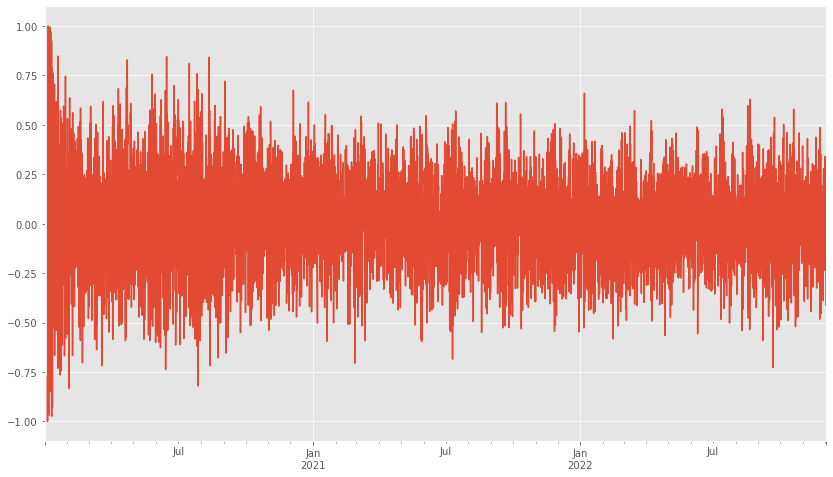

In [46]:
# axis=1，代表对每行求相关系数。这里设为1，代表按行，每行代表每一天，所以这里根据每天求相关系数。
IC_series = factor_processed.corrwith(tmr_ret, axis=1)
IC_series.plot()

In [80]:
IC_series.mean() / IC_series.std()

0.036587158804288075

<AxesSubplot:>

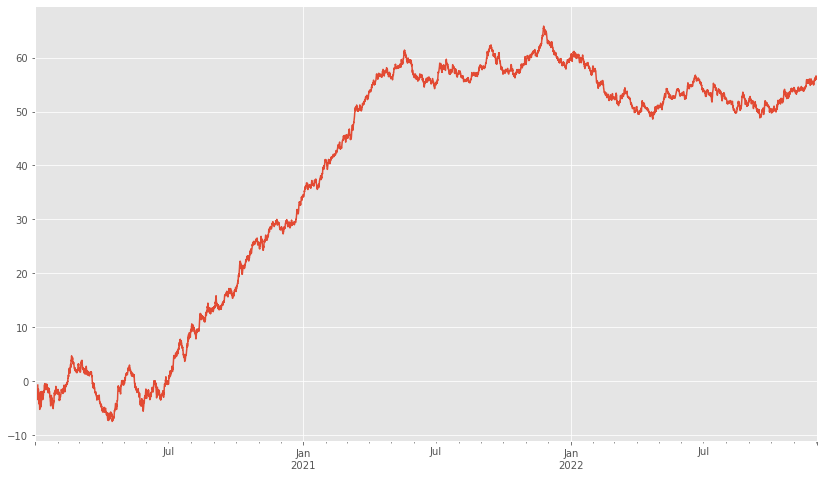

In [47]:
IC_series.cumsum().plot() #累计曲线能看出趋势

### Rank IC
Rank IC: 对因子值与明天收益率求rank，然后计算相关系数。
两个变量分别求排名rank，再计算2个rank的相关系数教Spearman相关系数。

In [78]:
 tmr_ret.iloc[:-1,0]

datetime
2020-01-01 08:00:00    0.005122
2020-01-01 12:00:00   -0.000434
2020-01-01 16:00:00   -0.003983
2020-01-01 20:00:00   -0.009764
2020-01-02 00:00:00   -0.002768
                         ...   
2022-12-01 12:00:00   -0.001479
2022-12-01 16:00:00    0.001481
2022-12-01 20:00:00   -0.004514
2022-12-02 00:00:00    0.003149
2022-12-02 04:00:00    0.000614
Freq: 4H, Name: BTC_USDT, Length: 6396, dtype: float64

In [79]:
# from scipy.stats.stats import pearsonr
# pearsonr(factor_processed.iloc[:-1,0], tmr_ret.iloc[:-1,0])

<AxesSubplot:>

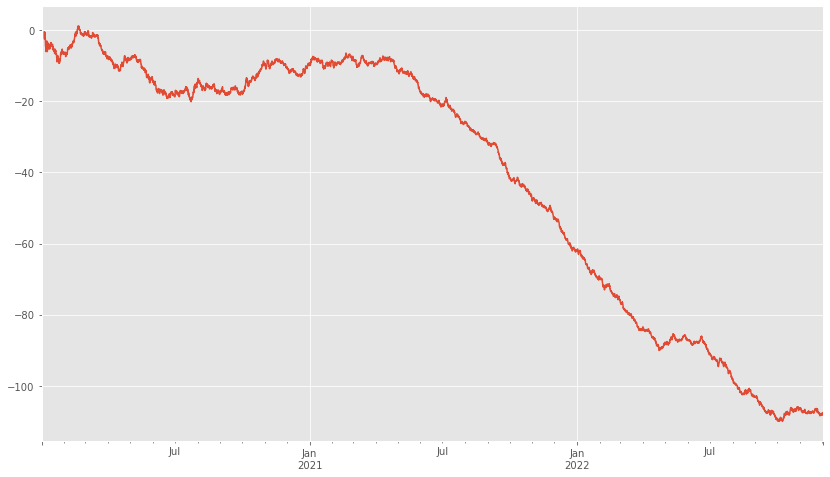

In [48]:
rank_IC_series = factor_processed.corrwith(tmr_ret, axis=1,
                                          method='spearman')
rank_IC_series.cumsum().plot()

### IR 和 胜率
IR: Information Ratio, IC的均值与标准差的比值，衡量IC稳定性。

胜率：IC 大于0的比率，与 0.5 相差越多越好。(因子无效时，即有时IC>0有时IC<0，此时胜率为0.5。若因子有效，则胜率远离0.5)

In [50]:
IR = rank_IC_series.mean() / rank_IC_series.std()
print(f"IR: {IR}")
    
win_rate = (rank_IC_series > 0).sum() / rank_IC_series.count()
print(f"win rate: {win_rate}")

IR: -0.07539388066982727
win rate: 0.4672208281053952


### 分层测试
每一层要能区分开。

In [67]:
ret1_list=[]
ret2_list=[]
ret3_list=[]
ret4_list=[]
ret5_list=[]

factor_processed_dropna = factor_processed.dropna()

# -1,为了去掉最后一行数据，以为因子的最后一行数据，没有对应的未来一天的return。
for i in range(len(factor_processed_dropna) - 1):
    # 根据因子值的大小，从小到大分成q类。
    factor_class = pd.qcut(factor_processed_dropna.iloc[i], q=5, labels=False)
    
    # 标签为0组的平均收益率。这里使用tmr_ret，代表未来1天的收益
    # 或者使用原有的return, return.iloc[i+1]
    ret1 = tmr_ret.iloc[i].loc[factor_class == 0].mean()
    ret2 = tmr_ret.iloc[i].loc[factor_class == 1].mean()
    ret3 = tmr_ret.iloc[i].loc[factor_class == 2].mean()
    ret4 = tmr_ret.iloc[i].loc[factor_class == 3].mean()
    ret5 = tmr_ret.iloc[i].loc[factor_class == 4].mean()
    
    ret1_list.append(ret1)
    ret2_list.append(ret2)
    ret3_list.append(ret3)
    ret4_list.append(ret4)
    ret5_list.append(ret5)

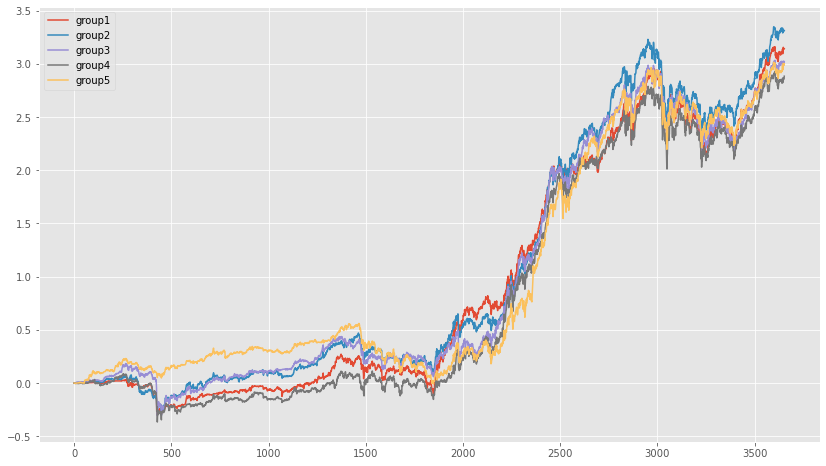

In [68]:
plt.plot(pd.Series(ret1_list).cumsum(), label="group1")
plt.plot(pd.Series(ret2_list).cumsum(), label="group2")
plt.plot(pd.Series(ret3_list).cumsum(), label="group3")
plt.plot(pd.Series(ret4_list).cumsum(), label="group4")
plt.plot(pd.Series(ret5_list).cumsum(), label="group5")
plt.legend()

In [65]:
factor_rank = factor_processed_dropna.rank(axis=1)
factor_rank

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
2021-04-02 12:00:00,59.0,20.0,48.0,21.0,52.0,11.0,7.0,12.0,58.0,35.0,...,9.0,18.0,15.0,6.0,36.0,41.0,54.0,50.0,56.0,39.0
2021-04-02 16:00:00,59.0,20.0,53.0,18.0,52.0,15.0,7.0,13.0,57.0,41.0,...,10.0,21.0,24.0,4.0,29.0,51.0,54.0,46.0,56.0,37.0
2021-04-02 20:00:00,57.0,26.0,56.0,12.0,51.0,16.0,4.0,14.0,58.0,35.0,...,10.0,19.0,42.0,6.0,27.0,53.0,48.0,47.0,50.0,45.0
2021-04-03 00:00:00,56.0,35.0,54.0,9.0,57.0,18.0,5.0,16.0,50.0,29.0,...,12.0,21.0,46.0,4.0,20.0,58.0,43.0,47.0,49.0,52.0
2021-04-03 04:00:00,56.0,42.0,52.0,16.0,57.0,18.0,9.0,13.0,54.0,32.0,...,12.0,23.0,30.0,14.0,22.0,59.0,44.0,46.0,45.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,44.0,3.0,48.0,14.0,4.0,32.0,34.0,19.0,55.0,27.0,...,38.0,21.0,45.0,24.0,6.0,53.0,25.0,29.0,49.0,26.0
2022-12-01 20:00:00,38.0,3.0,46.0,13.0,5.0,26.0,29.0,18.0,52.0,21.0,...,42.0,27.0,40.0,37.0,6.0,54.0,28.0,25.0,51.0,32.0
2022-12-02 00:00:00,39.0,3.0,46.0,13.0,5.0,30.0,24.0,21.0,48.0,22.0,...,44.0,26.0,40.0,33.0,6.0,55.0,29.0,28.0,49.0,36.0
2022-12-02 04:00:00,38.0,3.0,43.0,13.0,4.0,29.0,30.0,24.0,52.0,23.0,...,49.0,26.0,46.0,21.0,5.0,57.0,17.0,28.0,53.0,36.0


In [66]:
period=20
factor_rank.corrwith(factor_rank.shift(20), axis=1)

2021-04-02 12:00:00         NaN
2021-04-02 16:00:00         NaN
2021-04-02 20:00:00         NaN
2021-04-03 00:00:00         NaN
2021-04-03 04:00:00         NaN
                         ...   
2022-12-01 16:00:00    0.503397
2022-12-01 20:00:00    0.466452
2022-12-02 00:00:00    0.431560
2022-12-02 04:00:00    0.366511
2022-12-02 08:00:00    0.366511
Length: 3654, dtype: float64

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [44]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

ModuleNotFoundError: No module named 'zipline'

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [ ]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    factor = -(Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank(ascending=True) \
        .zscore())
    
    return factor


project_tests.test_mean_reversion_5day_sector_neutral(mean_reversion_5day_sector_neutral)

### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [ ]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [80]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    unsmoothed_factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    factor = SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length)\
    .rank()\
    .zscore()
    
    return factor


project_tests.test_mean_reversion_5day_sector_neutral_smoothed(mean_reversion_5day_sector_neutral_smoothed)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2015-01-05', tz='utc')
> end_date = pd.Timestamp('2015-01-07', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral_smoothed(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
> engine.run_pipeline(pipeline, start_dat, end_date)

Tests Passed


### View Data
Let's see what some of the smoothed data looks like.

In [81]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                        1.11580784
                          Equity(1 [AAL])                                      1.72840822
                          Equity(2 [AAP])                                      1.34188655
                          Equity(3 [AAPL])                                     0.91160771
                          Equity(4 [ABBV])                                     0.96265774
                          Equity(5 [ABC])                                      0.77304334
                          Equity(6 [ABT])                                      0.48862173
                          Equity(7 [ACN])                                     -0.45945029
                          Equity(8 [ADBE])                                     0.81680051
                          Equity(9 [ADI])                                      0.94807202
                          Equity(10 [ADM])                                     0.73657903
                          Equity(11 [ADP])                                     0.32088591
                          Equity(12 [ADS])                                    -1.59713671
                          Equity(13 [ADSK])                                    0.08022148
                          Equity(14 [AEE])                                     0.11668579
                          Equity(15 [AEP])                                     0.21878585
                          Equity(16 [AES])                                    -0.75116475
                          Equity(17 [AET])                                    -1.09392925
                          Equity(18 [AFL])                                    -0.07292862
                          Equity(19 [AGN])                                    -0.37922881
                          Equity(20 [AIG])                                     1.05017208
                          Equity(21 [AIV])                                    -0.14585723
                          Equity(22 [AIZ])                                     0.67094327
                          Equity(23 [AJG])                                    -0.56155035
                          Equity(24 [AKAM])                                    1.67735818
                          Equity(25 [ALB])                                     1.35647227
                          Equity(26 [ALGN])                                    1.32730082
                          Equity(27 [ALK])                                     0.57613607
                          Equity(28 [ALL])                                     0.02187859
                          Equity(29 [ALLE])                                    1.65547960
...                                                                                   ...
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                                   1.12262790
                          Equity(461 [VRTX])                                  -1.62157363
                          Equity(462 [VTR])                                   -1.60731804
                          Equity(463 [VZ])                                    -1.68572380
                          Equity(464 [WAT])                                   -1.00858316
                          Equity(465 [WBA])                                    0.98007198
                          Equity(466 [WDC])                                   -1.22241705
                          Equity(467 [WEC])                                   -0.78762148
                          Equity(468 [WFC])                                    0.72347131
                          Equity(469 [WHR])                                    0.37420930
                          Equity(471 [WM])                                    -0.53814861
                          Equity(472 [WMB])                                   -1.65721261
                          Equity(473 [WMT])                                   -1.41486

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [82]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [83]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [84]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                             0.85326482   
                          Equity(1 [AAL])                           1.62630815   
                          Equity(2 [AAP])                           0.64906469   
                          Equity(3 [AAPL])                          1.40752230   
                          Equity(4 [ABBV])                          1.45857233   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                      1.11580784   
                          Equity(1 [AAL])                                    1.72840822   
                          Equity(2 [AAP])                                    1.34188655   
                          Equity(3 [AAPL])                                   0.91160771   
                          Equity(4 [ABBV])                                   0.96265774   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])       1.49939067           0.70659131   
                          Equity(1 [AAL])     1.60279693          -1.70668978   
                          Equity(2 [AAP])     0.37669421           0.03261191   
                          Equity(3 [AAPL])   -1.48461835          -1.67770142   
                          Equity(4 [ABBV])    0.91588396          -1.47478289   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                       1.11242837  
                          Equity(1 [AAL])                    -1.72843105  
                          Equity(2 [AAP])                    -0.62687332  
                          Equity(3 [AAPL])                    0.53990823  
                          Equity(4 [ABBV])                   -0.06160027

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [85]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [86]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

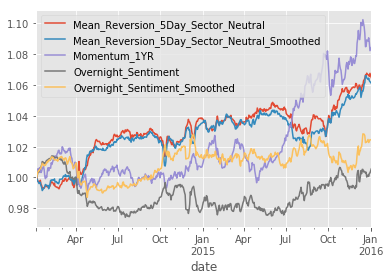

In [87]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7087a80f0>,
      dtype=object)

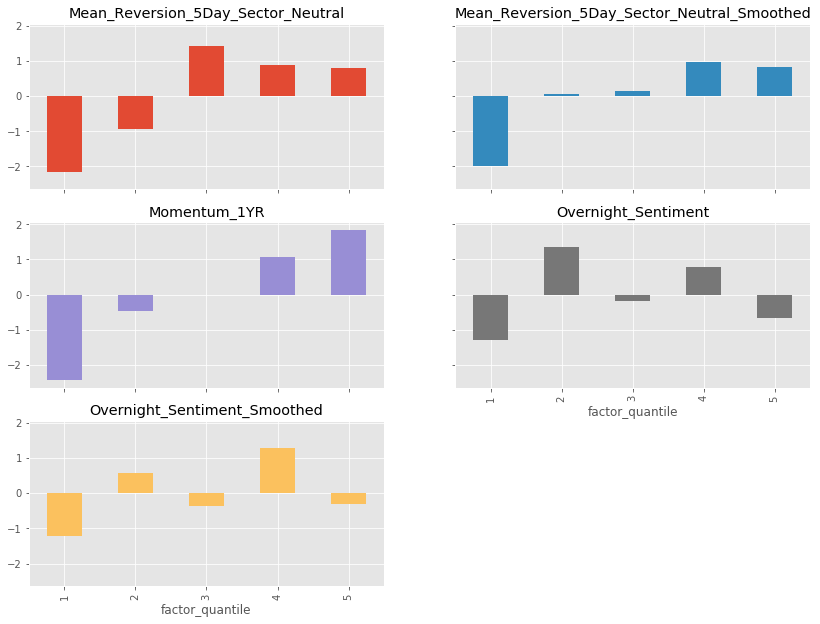

In [88]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

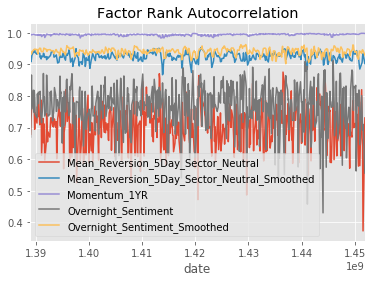

In [89]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [90]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    sharpe_ratio = annualization_factor * factor_returns.mean() / factor_returns.std()
    
    return sharpe_ratio


project_tests.test_sharpe_ratio(sharpe_ratio)

Tests Passed


### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [91]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            1.37000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   1.27000000
Momentum_1YR                                  1.13000000
Overnight_Sentiment                           0.12000000
Overnight_Sentiment_Smoothed                  0.45000000
dtype: float64

## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?


**Answer:** 
As here momentum is defined and computed as rolling 1 year returns, this is already a very robust estimate (the rate of change can also be computed as a momentum indicator for example, this one being more noisy) and further smoothing the factor would have no effect. This is supported also by the factor rank autocorrelation, as we can autocorrelation for momentum is close to 1 and very stable over time.

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [92]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
Equity(0 [A]),-0.58642457
Equity(1 [AAL]),-0.45333845
Equity(2 [AAP]),-0.69993898
Equity(3 [AAPL]),-0.06790952
Equity(4 [ABBV]),-1.21617871


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [93]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [124]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        objective = cvx.Maximize(alpha_vector.T.values * weights)
        
        return objective
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        constraints = [risk <= self.risk_cap**2, 
                      factor_betas.T * weights <= self.factor_max,
                      factor_betas.T * weights >= self.factor_min,
                      sum(weights) == 0.0,
                      sum(cvx.abs(weights)) <= 1.0,
                      weights >= self.weights_min,
                      weights <= self.weights_max]
        
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed

Running Integration Test on Problem.solve:
> x = np.diag(np.arange(3))
> s = np.diag(np.arange(4))
> factor_betas = np.arange(4 * 3).reshape([4, 3])
> risk = cvx.quad_form(weights * factor_betas, x) + cvx.quad_form(weights, s)
> constaints = optimal_holdings._get_constraints(weights, factor_betas, risk)
> obj = cvx.Maximize([0, 1, 5, -1] * weights)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


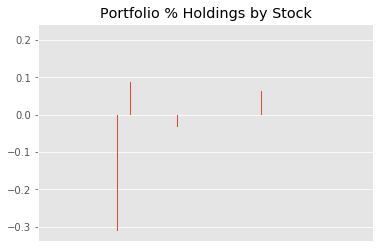

In [125]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

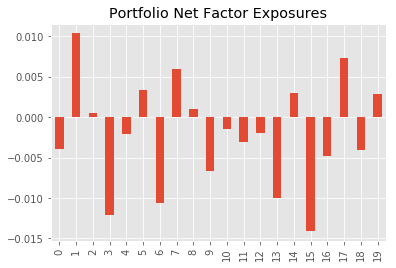

In [126]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [130]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        objective = cvx.Maximize(alpha_vector.T.values * weights - self.lambda_reg * cvx.norm(weights, 2))
        
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_regualization._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


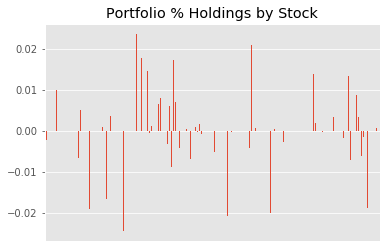

In [131]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

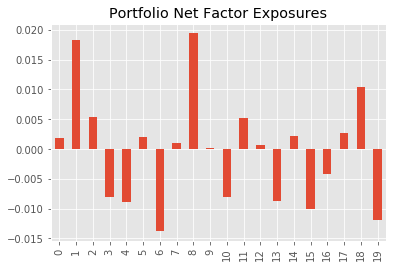

In [132]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [142]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        alpha_vector_norm = ((alpha_vector.values - alpha_vector.values.mean()) / np.sum(np.abs(alpha_vector.values))).flatten()
        objective = cvx.Minimize(cvx.norm(weights - alpha_vector_norm))
        
        return objective


project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


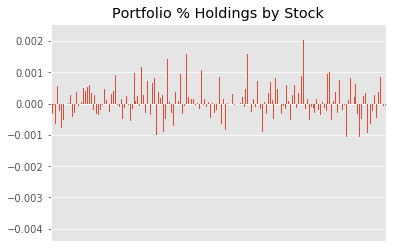

In [143]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

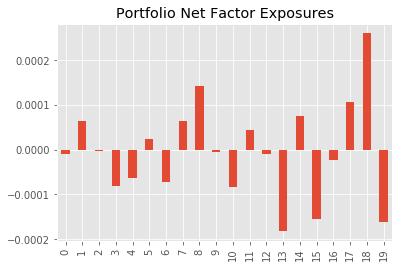

In [144]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.